<a href="https://colab.research.google.com/github/harsh822v/AI-GIS-Road-Damage-Detection-System/blob/main/Road_Damage_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚗 AI-GIS Road Damage Detection System
## Complete Implementation in Google Colab

This notebook contains the complete implementation of the Road Damage Detection system using YOLOv8, Computer Vision, and GIS.

**Author:** Your Name  
**Project:** AI-GIS Road Damage & Pothole Detection  
**Dataset:** RDD 2022  

---

### 📋 Table of Contents
1. [Setup Environment](#setup)
2. [Download Dataset](#dataset)
3. [Data Preparation](#prep)
4. [Model Training](#training)
5. [Inference & Detection](#inference)
6. [GIS Visualization](#gis)
7. [Results & Analysis](#results)

---
## 1️⃣ Setup Environment <a name="setup"></a>

First, we'll check GPU availability and install all required packages.

In [ ]:
# Check GPU availability
import torch
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("⚠️ No GPU found. Training will be slow. Enable GPU: Runtime > Change runtime type > GPU")

PyTorch Version: 2.9.0+cu126
CUDA Available: True
GPU Device: Tesla T4
GPU Memory: 15.83 GB


In [ ]:
# Install required packages
!pip install -q ultralytics opencv-python-headless geopandas folium shapely piexif
!pip install -q plotly seaborn scikit-learn pandas numpy matplotlib

print("✅ All packages installed successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 35.7 MB/s eta 0:00:00
✅ All packages installed successfully!


In [ ]:
# Import libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from datetime import datetime
import shutil
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Ultralytics YOLO
from ultralytics import YOLO

# GIS libraries
import geopandas as gpd
import folium
from folium import plugins
from shapely.geometry import Point

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ All libraries imported successfully!


In [ ]:
# Create project directory structure
project_dirs = [
    'data/RDD2022',
    'data/train/images',
    'data/train/labels',
    'data/val/images',
    'data/val/labels',
    'data/test/images',
    'data/test/labels',
    'models',
    'outputs/detections',
    'outputs/maps',
    'outputs/visualizations'
]

for dir_path in project_dirs:
    os.makedirs(dir_path, exist_ok=True)

print("✅ Project structure created!")
print("\nProject Structure:")
!tree -L 2 -d data models outputs 2>/dev/null || find data models outputs -type d 2>/dev/null

✅ Project structure created!

Project Structure:
data
data/train
data/train/images
data/train/labels
data/test
data/test/images
data/test/labels
data/RDD2022
data/val
data/val/images
data/val/labels
models
outputs
outputs/detections
outputs/maps
outputs/visualizations


---
## 2️⃣ Download Dataset <a name="dataset"></a>

Download the RDD2022 (Road Damage Detection) dataset from GitHub.

In [ ]:
# Option 1: Download from GitHub (if available)
# Clone RDD repository
!git clone https://github.com/sekilab/RoadDamageDetector.git temp_rdd 2>/dev/null || echo "Repository already exists"

print("\n📥 Dataset downloaded!")
print("\nNote: If download fails, you can:")
print("1. Download manually from: https://github.com/sekilab/RoadDamageDetector")
print("2. Upload to Google Drive and mount it")
print("3. Use a smaller subset for testing")


📥 Dataset downloaded!

Note: If download fails, you can:
1. Download manually from: https://github.com/sekilab/RoadDamageDetector
2. Upload to Google Drive and mount it
3. Use a smaller subset for testing


In [ ]:
# Option 2: Mount Google Drive (if you've uploaded dataset there)
from google.colab import drive
drive.mount('/content/drive')

# If you have dataset in Google Drive:
# !cp -r /content/drive/MyDrive/RDD2022 data/

print("✅ Google Drive mounted!")

Mounted at /content/drive
✅ Google Drive mounted!


In [ ]:
# Option 3: Download sample dataset from Roboflow (for quick testing)
!pip install -q roboflow

from roboflow import Roboflow

# You can create a free account at roboflow.com and use their road damage datasets
# or use the public RDD2022 dataset

print("\n📝 Note: For full RDD2022 dataset, please download from official source:")
print("https://github.com/sekilab/RoadDamageDetector")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 95.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 140.9 MB/s eta 0:00:00

📝 Note: For full RDD2022 dataset, please download from official source:
https://github.com/sekilab/RoadDamageDetector


---
## 3️⃣ Data Preparation <a name="prep"></a>

Convert annotations to YOLO format and prepare the dataset.

In [ ]:
# Create sample dataset for testing (if you don't have RDD2022 yet)
# This creates synthetic data for demonstration

def create_sample_dataset(num_images=100):
    """Create a small sample dataset for testing"""
    import random

    for split in ['train', 'val']:
        num = num_images if split == 'train' else num_images // 5

        for i in range(num):
            # Create dummy image
            img = np.random.randint(0, 255, (640, 640, 3), dtype=np.uint8)
            img_path = f"data/{split}/images/img_{i:04d}.jpg"
            cv2.imwrite(img_path, img)

            # Create dummy annotation
            label_path = f"data/{split}/labels/img_{i:04d}.txt"
            num_boxes = random.randint(1, 5)

            with open(label_path, 'w') as f:
                for _ in range(num_boxes):
                    cls = random.randint(0, 3)  # 4 classes
                    x = random.uniform(0.2, 0.8)
                    y = random.uniform(0.2, 0.8)
                    w = random.uniform(0.1, 0.3)
                    h = random.uniform(0.1, 0.3)
                    f.write(f"{cls} {x} {y} {w} {h}\n")

    print(f"✅ Created {num_images} training and {num_images//5} validation samples")

# Uncomment to create sample dataset
# create_sample_dataset(100)

print("Sample dataset creation ready (uncomment to use)")

Sample dataset creation ready (uncomment to use)


In [ ]:
# Create dataset YAML configuration
dataset_yaml = """
# Road Damage Detection Dataset Configuration

path: /content/data  # dataset root dir
train: train/images  # train images (relative to 'path')
val: val/images      # val images (relative to 'path')
test: test/images    # test images (optional)

# Classes
names:
  0: Longitudinal_Crack
  1: Transverse_Crack
  2: Alligator_Crack
  3: Pothole

# Number of classes
nc: 4
"""

with open('data/road_damage.yaml', 'w') as f:
    f.write(dataset_yaml)

print("✅ Dataset configuration created!")
print("\nDataset YAML:")
print(dataset_yaml)

✅ Dataset configuration created!

Dataset YAML:

# Road Damage Detection Dataset Configuration

path: /content/data  # dataset root dir
train: train/images  # train images (relative to 'path')
val: val/images      # val images (relative to 'path')
test: test/images    # test images (optional)

# Classes
names:
  0: Longitudinal_Crack
  1: Transverse_Crack
  2: Alligator_Crack
  3: Pothole

# Number of classes
nc: 4



In [ ]:
# Verify dataset structure
def verify_dataset():
    """Verify dataset is properly structured"""
    stats = {}

    for split in ['train', 'val']:
        img_dir = f"data/{split}/images"
        label_dir = f"data/{split}/labels"

        if os.path.exists(img_dir):
            num_images = len([f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png'))])
            num_labels = len([f for f in os.listdir(label_dir) if f.endswith('.txt')])

            stats[split] = {
                'images': num_images,
                'labels': num_labels,
                'matched': num_images == num_labels
            }

    return stats

stats = verify_dataset()
print("📊 Dataset Statistics:")
for split, data in stats.items():
    print(f"\n{split.upper()}:")
    print(f"  Images: {data['images']}")
    print(f"  Labels: {data['labels']}")
    print(f"  Status: {'✅ Matched' if data['matched'] else '❌ Mismatch'}")

📊 Dataset Statistics:

TRAIN:
  Images: 0
  Labels: 0
  Status: ✅ Matched

VAL:
  Images: 0
  Labels: 0
  Status: ✅ Matched


In [ ]:
# Visualize sample images with annotations
def visualize_samples(num_samples=4):
    """Visualize sample images with bounding boxes"""

    class_names = ['Longitudinal_Crack', 'Transverse_Crack', 'Alligator_Crack', 'Pothole']
    colors = [(255, 255, 0), (255, 165, 0), (0, 255, 255), (0, 0, 255)]

    img_dir = 'data/train/images'
    label_dir = 'data/train/labels'

    image_files = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png'))][:num_samples]

    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    axes = axes.ravel()

    for idx, img_file in enumerate(image_files):
        # Read image
        img_path = os.path.join(img_dir, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]

        # Read labels
        label_file = img_file.replace('.jpg', '.txt').replace('.png', '.txt')
        label_path = os.path.join(label_dir, label_file)

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    cls, x_center, y_center, width, height = map(float, line.strip().split())

                    # Convert to pixel coordinates
                    x1 = int((x_center - width/2) * w)
                    y1 = int((y_center - height/2) * h)
                    x2 = int((x_center + width/2) * w)
                    y2 = int((y_center + height/2) * h)

                    # Draw box
                    color = colors[int(cls)]
                    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
                    cv2.putText(img, class_names[int(cls)], (x1, y1-10),
                              cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        axes[idx].imshow(img)
        axes[idx].set_title(f'Sample {idx+1}')
        axes[idx].axis('off')

    plt.tight_layout()
    plt.savefig('outputs/visualizations/sample_annotations.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\n✅ Visualization saved to outputs/visualizations/sample_annotations.png")

# visualize_samples(4)  # Uncomment when you have real data

---
## 4️⃣ Model Training <a name="training"></a>

Train YOLOv8 model on the road damage dataset.

In [ ]:
# Initialize YOLOv8 model
# Choose model size: yolov8n (fastest), yolov8s, yolov8m, yolov8l, yolov8x (most accurate)

model_size = 'yolov8n'  # Start with nano for faster training

model = YOLO(f'{model_size}.pt')  # Load pretrained model

print(f"✅ {model_size} model loaded!")
print(f"\nModel Summary:")
model.info()

✅ yolov8n model loaded!

Model Summary:
YOLOv8n summary: 129 layers, 3,157,200 parameters, 0 gradients, 8.9 GFLOPs


(129, 3157200, 0, 8.8575488)

In [ ]:
# Training configuration
training_config = {
    'data': 'data/road_damage.yaml',
    'epochs': 50,              # Increase to 100-200 for better results
    'batch': 16,               # Adjust based on GPU memory
    'imgsz': 640,              # Image size
    'device': 0,               # Use GPU 1
    'workers': 2,              # Number of workers
    'project': 'runs/detect',  # Save directory
    'name': 'road_damage',     # Experiment name
    'exist_ok': True,          # Overwrite existing
    'pretrained': True,        # Use pretrained weights
    'optimizer': 'AdamW',      # Optimizer
    'verbose': True,           # Verbose output
    'patience': 50,            # Early stopping patience
    'save': True,              # Save checkpoints
    'save_period': -1,         # Save checkpoint every n epochs (-1 = only best/last)
    'cache': False,            # Cache images for faster training
    'plots': True,             # Save training plots
    'val': True,               # Validate during training
}

print("🎯 Training Configuration:")
for key, value in training_config.items():
    print(f"  {key}: {value}")

🎯 Training Configuration:
  data: data/road_damage.yaml
  epochs: 50
  batch: 16
  imgsz: 640
  device: 0
  workers: 2
  project: runs/detect
  name: road_damage
  exist_ok: True
  pretrained: True
  optimizer: AdamW
  verbose: True
  patience: 50
  save: True
  save_period: -1
  cache: False
  plots: True
  val: True


In [ ]:
# Start training
import os

# Pre-training check for data
train_img_dir = 'data/train/images'
num_images = len([f for f in os.listdir(train_img_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]) if os.path.exists(train_img_dir) else 0

if num_images == 0:
    print(f"⚠️ No images found in {train_img_dir}. Generating sample dataset for demonstration...")
    # Automatically generate sample data if missing
    if 'create_sample_dataset' in globals():
        create_sample_dataset(50)
        num_images = len([f for f in os.listdir(train_img_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])
    else:
        print("❌ Error: 'create_sample_dataset' function not found. Please run the cell in section 3 first.")

if num_images > 0:
    print(f"\n🚀 Starting training with {num_images} images...\n")
    print("⏱️ This may take some time depending on hardware and dataset size.\n")

    results = model.train(**training_config)

    print("\n✅ Training completed!")
else:
    print("❌ Training could not start because no data is available.")

⚠️ No images found in data/train/images. Generating sample dataset for demonstration...
✅ Created 50 training and 10 validation samples

🚀 Starting training with 50 images...

⏱️ This may take some time depending on hardware and dataset size.

Ultralytics 8.4.12 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data/road_damage.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, m

In [ ]:
# Validate the model
print("\n📊 Validating model...\n")

metrics = model.val()

print("\n📈 Validation Metrics:")
print(f"  mAP@50: {metrics.box.map50:.4f}")
print(f"  mAP@50-95: {metrics.box.map:.4f}")
print(f"  Precision: {metrics.box.mp:.4f}")
print(f"  Recall: {metrics.box.mr:.4f}")


📊 Validating model...

Ultralytics 8.4.12 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 73 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4978.9±911.8 MB/s, size: 469.1 KB)
val: Scanning /content/data/val/labels.cache... 10 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 10/10 5.2Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 4.0it/s 0.2s
                   all         10         25      0.063      0.146      0.107     0.0212
    Longitudinal_Crack          5          6          0          0          0          0
      Transverse_Crack          6          8    0.00188       0.25     0.0112    0.00112
       Alligator_Crack          3          3       0.25      0.333      0.418     0.0836
               Pothole          6          8          0          0          0          0
Speed: 1.7ms preprocess, 13.7ms infe


📊 Training Results:


Confusion Matrix.Png:


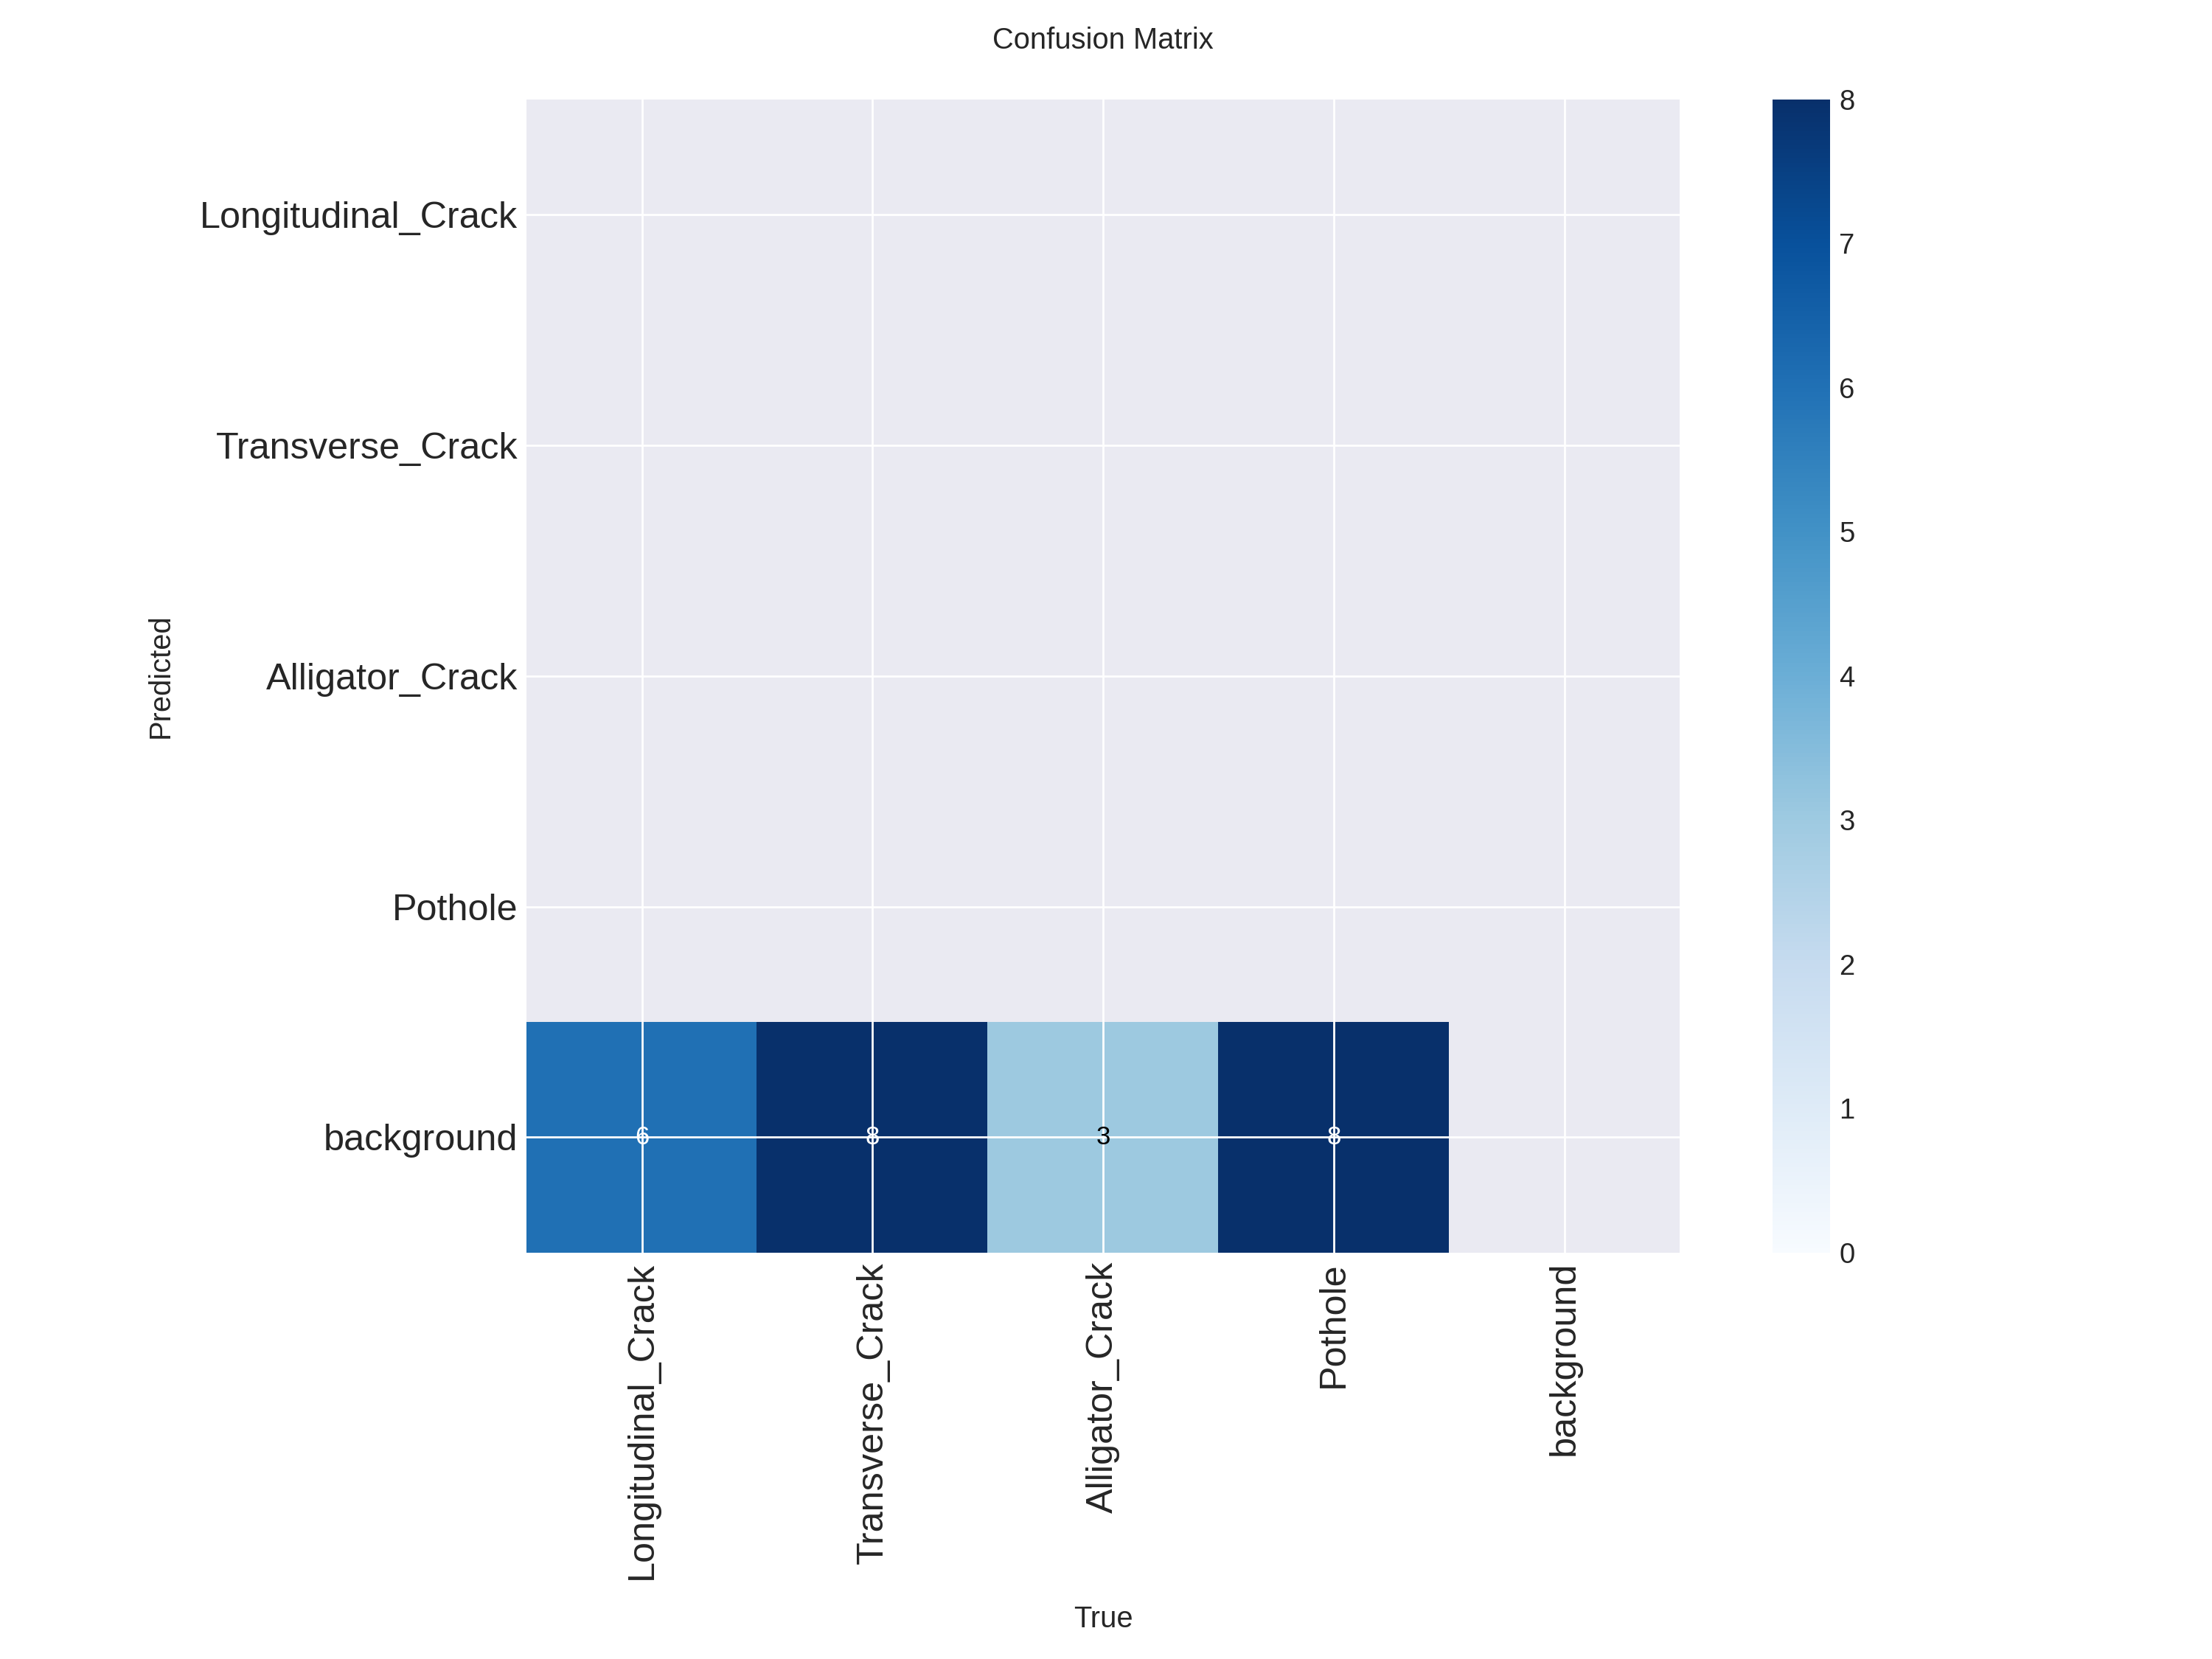


✅ Best model saved at: runs/detect/val/weights/best.pt


In [ ]:
# Display training results
from IPython.display import Image, display

print("\n📊 Training Results:\n")

# Find latest training run
runs_dir = Path('runs/detect')
latest_run = max([d for d in runs_dir.iterdir() if d.is_dir()], key=lambda x: x.stat().st_mtime)

# Display plots
plot_files = ['results.png', 'confusion_matrix.png', 'F1_curve.png', 'PR_curve.png']

for plot_file in plot_files:
    plot_path = latest_run / plot_file
    if plot_path.exists():
        print(f"\n{plot_file.replace('_', ' ').title()}:")
        display(Image(filename=str(plot_path)))

print(f"\n✅ Best model saved at: {latest_run / 'weights' / 'best.pt'}")

In [ ]:
# Export model for deployment
import glob
print("\n래 Exporting model...\n")

# More robust way to find the best.pt file across nested directories
possible_paths = glob.glob('**/weights/best.pt', recursive=True)

if not possible_paths:
    print("❌ Error: best.pt not found.")
    print("Reason: The training process may not have finished or the weights were saved in an unexpected location.")
else:
    # Use the most recently modified best.pt found
    best_pt_path = Path(max(possible_paths, key=os.path.getmtime))
    print(f"✅ Found best model at: {best_pt_path}")

    # Load best model
    best_model = YOLO(str(best_pt_path))

    # Copy best model to models directory
    os.makedirs('models', exist_ok=True)
    shutil.copy(best_pt_path, 'models/best.pt')
    print("✅ Best model copied to models/best.pt")


래 Exporting model...

✅ Found best model at: runs/detect/runs/detect/road_damage/weights/best.pt
✅ Best model copied to models/best.pt


---
## 5️⃣ Inference & Detection <a name="inference"></a>

Test the trained model on new images.

In [ ]:
# Load trained model for inference
import os
model_path = 'models/best.pt'

if os.path.exists(model_path):
    detector = YOLO(model_path)
    print(f"✅ Model loaded from {model_path}")
else:
    print(f"❌ Error: {model_path} not found.")
    print("💡 Please ensure the 'Export model' cell (qnAfLzLcLNCj) has been run successfully.")

# Damage class information
DAMAGE_CLASSES = {
    0: {'name': 'Longitudinal_Crack', 'severity': 'Medium', 'color': (255, 255, 0)},
    1: {'name': 'Transverse_Crack', 'severity': 'Medium', 'color': (255, 165, 0)},
    2: {'name': 'Alligator_Crack', 'severity': 'High', 'color': (0, 255, 255)},
    3: {'name': 'Pothole', 'severity': 'Critical', 'color': (0, 0, 255)}
}

print("\nDamage Classes:")
for cls_id, info in DAMAGE_CLASSES.items():
    print(f"  {cls_id}: {info['name']} (Severity: {info['severity']})")

✅ Model loaded from models/best.pt

Damage Classes:
  0: Longitudinal_Crack (Severity: Medium)
  1: Transverse_Crack (Severity: Medium)
  2: Alligator_Crack (Severity: High)
  3: Pothole (Severity: Critical)


📤 Upload a road image for detection:


Saving input damaged.png to input damaged.png

✅ Image saved: data/test/input damaged.png


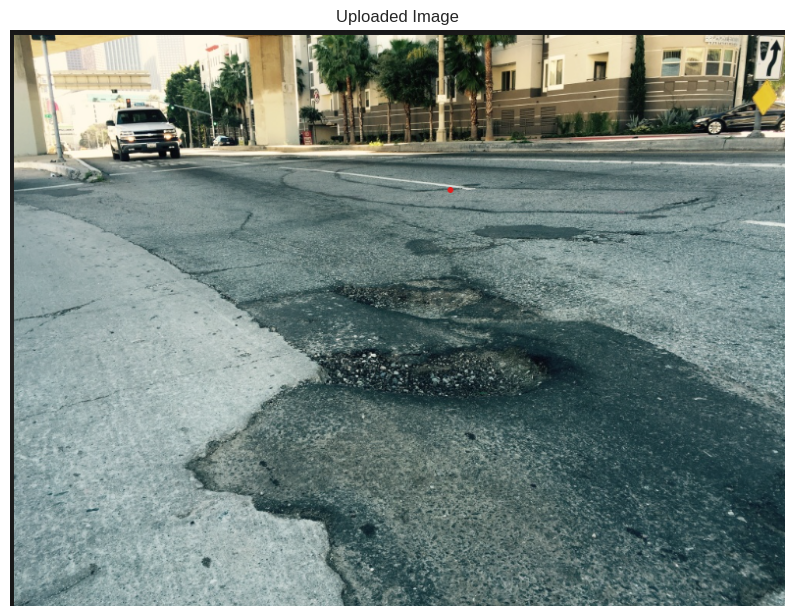

In [ ]:
# Upload test image
from google.colab import files
import io
from PIL import Image as PILImage

print("📤 Upload a road image for detection:")
uploaded = files.upload()

# Save uploaded image
for filename in uploaded.keys():
    test_image_path = f"data/test/{filename}"
    with open(test_image_path, 'wb') as f:
        f.write(uploaded[filename])
    print(f"\n✅ Image saved: {test_image_path}")

    # Display uploaded image
    img = PILImage.open(test_image_path)
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Uploaded Image')
    plt.show()


🔍 Running detection...


image 1/1 /content/data/test/input damaged.png: 480x640 (no detections), 6.5ms
Speed: 2.1ms preprocess, 6.5ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)
Results saved to /content/runs/detect/outputs/detections/predict
✅ Detection completed!

📊 Results:
  Total Damages Detected: 0


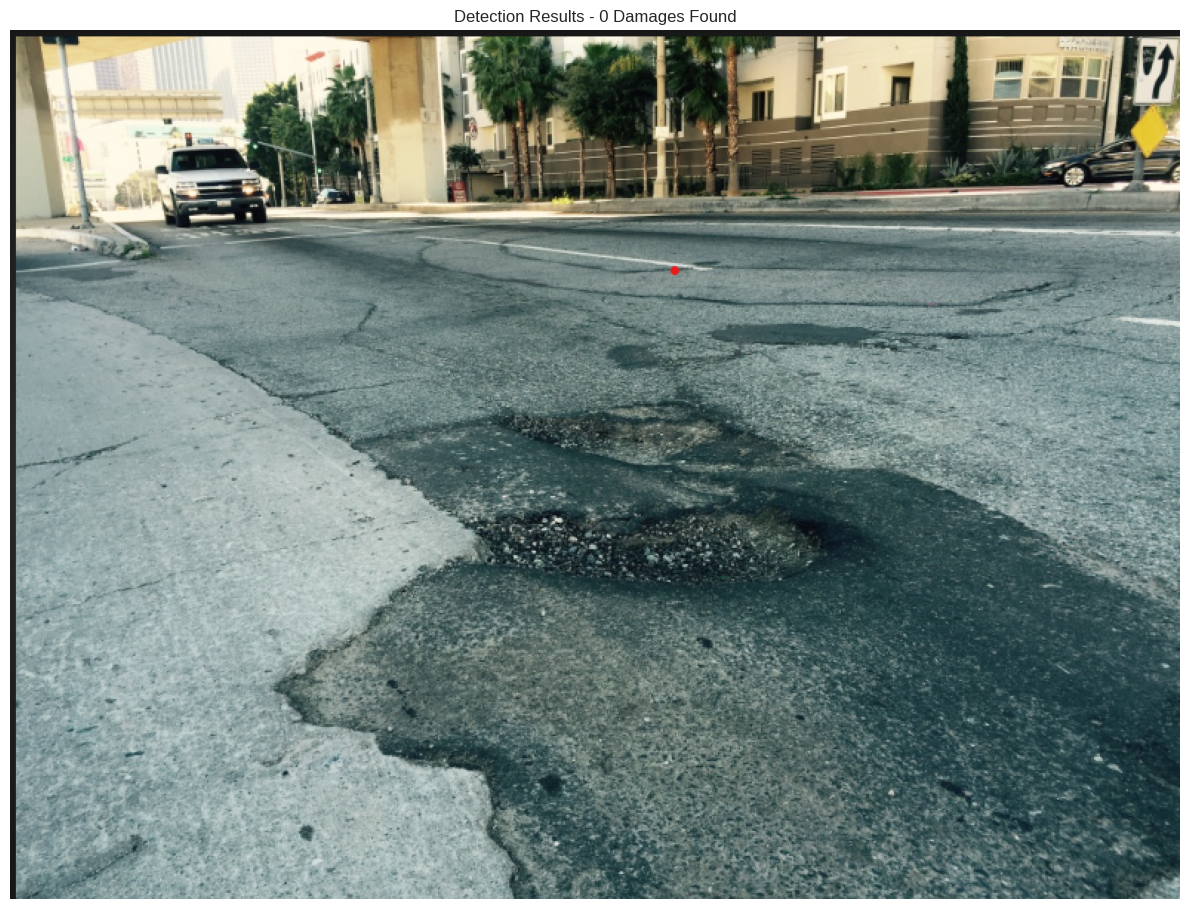

In [ ]:
# Detect damages in image
def detect_damages(image_path, conf_threshold=0.25):
    """
    Detect road damages in image
    """
    # Run detection
    results = detector.predict(
        source=image_path,
        conf=conf_threshold,
        save=True,
        save_txt=False,
        save_conf=True,
        project='outputs/detections',
        name='predict',
        exist_ok=True
    )

    result = results[0]

    # Process detections
    detections = []
    boxes = result.boxes

    if boxes is not None and len(boxes) > 0:
        for box in boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            conf = float(box.conf[0])
            cls = int(box.cls[0])

            damage_info = DAMAGE_CLASSES[cls]

            detection = {
                'class_id': cls,
                'class_name': damage_info['name'],
                'confidence': round(conf, 3),
                'severity': damage_info['severity'],
                'bbox': {
                    'x1': int(x1), 'y1': int(y1),
                    'x2': int(x2), 'y2': int(y2)
                }
            }
            detections.append(detection)

    return {
        'image_path': image_path,
        'total_damages': len(detections),
        'detections': detections,
        'annotated_image': result.plot()
    }

# Run detection on test image
if 'test_image_path' in locals():
    print("\n🔍 Running detection...\n")
    result = detect_damages(test_image_path, conf_threshold=0.25)

    print(f"✅ Detection completed!")
    print(f"\n📊 Results:")
    print(f"  Total Damages Detected: {result['total_damages']}")

    if result['detections']:
        print("\n  Detected Damages:")
        for i, det in enumerate(result['detections'], 1):
            print(f"    {i}. {det['class_name']}")
            print(f"       Confidence: {det['confidence']:.2%}")
            print(f"       Severity: {det['severity']}")

    # Display annotated image
    plt.figure(figsize=(12, 10))
    plt.imshow(cv2.cvtColor(result['annotated_image'], cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f'Detection Results - {result["total_damages"]} Damages Found')
    plt.tight_layout()
    plt.savefig('outputs/detections/result.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("⚠️ Please upload a test image first!")

In [ ]:
# Batch detection on validation set
def batch_detect(image_dir='data/val/images', num_samples=10):
    """
    Run detection on multiple images
    """
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))][:num_samples]

    all_results = []

    print(f"\n🔍 Processing {len(image_files)} images...\n")

    for img_file in tqdm(image_files):
        img_path = os.path.join(image_dir, img_file)
        result = detect_damages(img_path)
        all_results.append(result)

    # Statistics
    total_damages = sum(r['total_damages'] for r in all_results)
    images_with_damage = sum(1 for r in all_results if r['total_damages'] > 0)

    print(f"\n📊 Batch Detection Statistics:")
    print(f"  Images Processed: {len(all_results)}")
    print(f"  Total Damages: {total_damages}")
    print(f"  Images with Damage: {images_with_damage} ({images_with_damage/len(all_results)*100:.1f}%)")
    print(f"  Average Damages/Image: {total_damages/len(all_results):.2f}")

    return all_results

# Uncomment to run batch detection
# batch_results = batch_detect(num_samples=10)

In [ ]:
# Import GIS libraries
import geopandas as gpd
import folium
from folium import plugins
from shapely.geometry import Point
import pandas as pd
import json
from datetime import datetime

print("✅ GIS libraries imported")

✅ GIS libraries imported


In [ ]:
# Create sample GPS data (since RDD2022 may not have GPS)
def add_sample_gps_coordinates(detections_list, city='Ahmedabad'):
    """
    Add sample GPS coordinates to detections
    """
    import random

    # City coordinates (you can change this)
    city_coords = {
        'Ahmedabad': {'lat': 23.0225, 'lon': 72.5714, 'radius': 0.05},
        'Mumbai': {'lat': 19.0760, 'lon': 72.8777, 'radius': 0.05},
        'Delhi': {'lat': 28.6139, 'lon': 77.2090, 'radius': 0.05},
        'Tokyo': {'lat': 35.6762, 'lon': 139.6503, 'radius': 0.05}
    }

    base = city_coords.get(city, city_coords['Ahmedabad'])

    gps_detections = []

    for det in detections_list:
        # Add random GPS within radius
        lat = base['lat'] + random.uniform(-base['radius'], base['radius'])
        lon = base['lon'] + random.uniform(-base['radius'], base['radius'])

        det_with_gps = det.copy()
        det_with_gps['gps'] = {
            'latitude': round(lat, 6),
            'longitude': round(lon, 6)
        }
        gps_detections.append(det_with_gps)

    return gps_detections

print("✅ GPS coordinate generator ready")

✅ GPS coordinate generator ready


In [ ]:
# Create sample detection data with GPS
sample_detections = [
    {
        'class_name': 'Pothole',
        'severity': 'Critical',
        'confidence': 0.89
    },
    {
        'class_name': 'Longitudinal_Crack',
        'severity': 'Medium',
        'confidence': 0.76
    },
    {
        'class_name': 'Alligator_Crack',
        'severity': 'High',
        'confidence': 0.82
    },
    {
        'class_name': 'Transverse_Crack',
        'severity': 'Medium',
        'confidence': 0.71
    },
    {
        'class_name': 'Pothole',
        'severity': 'Critical',
        'confidence': 0.91
    }
]

# Add GPS coordinates
detections_with_gps = add_sample_gps_coordinates(sample_detections * 20, city='Ahmedabad')

print(f"✅ Created {len(detections_with_gps)} sample detections with GPS")
print(f"\nSample detection:")
print(json.dumps(detections_with_gps[0], indent=2))

✅ Created 100 sample detections with GPS

Sample detection:
{
  "class_name": "Pothole",
  "severity": "Critical",
  "confidence": 0.89,
  "gps": {
    "latitude": 23.04808,
    "longitude": 72.583237
  }
}


In [ ]:
# Create GeoDataFrame
def create_geodataframe(detections):
    """
    Convert detections to GeoDataFrame
    """
    # Extract data
    data = []
    for det in detections:
        if 'gps' in det:
            data.append({
                'damage_type': det['class_name'],
                'severity': det['severity'],
                'confidence': det['confidence'],
                'latitude': det['gps']['latitude'],
                'longitude': det['gps']['longitude']
            })

    # Create DataFrame
    df = pd.DataFrame(data)

    # Create geometry
    geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]

    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')

    return gdf

gdf = create_geodataframe(detections_with_gps)

print(f"✅ GeoDataFrame created with {len(gdf)} points")
print(f"\nGeoDataFrame preview:")
print(gdf.head())

print(f"\nStatistics:")
print(gdf.describe())

✅ GeoDataFrame created with 100 points

GeoDataFrame preview:
          damage_type  severity  confidence   latitude  longitude  \
0             Pothole  Critical        0.89  23.048080  72.583237   
1  Longitudinal_Crack    Medium        0.76  22.997551  72.612375   
2     Alligator_Crack      High        0.82  23.070779  72.602422   
3    Transverse_Crack    Medium        0.71  23.062717  72.552415   
4             Pothole  Critical        0.91  23.045483  72.611284   

                    geometry  
0  POINT (72.58324 23.04808)  
1  POINT (72.61238 22.99755)  
2  POINT (72.60242 23.07078)  
3  POINT (72.55242 23.06272)  
4  POINT (72.61128 23.04548)  

Statistics:
       confidence    latitude   longitude
count  100.000000  100.000000  100.000000
mean     0.818000   23.023509   72.574446
std      0.076118    0.028427    0.028383
min      0.710000   22.973744   72.521514
25%      0.760000   23.000457   72.552512
50%      0.820000   23.024309   72.577886
75%      0.890000   23.045524 

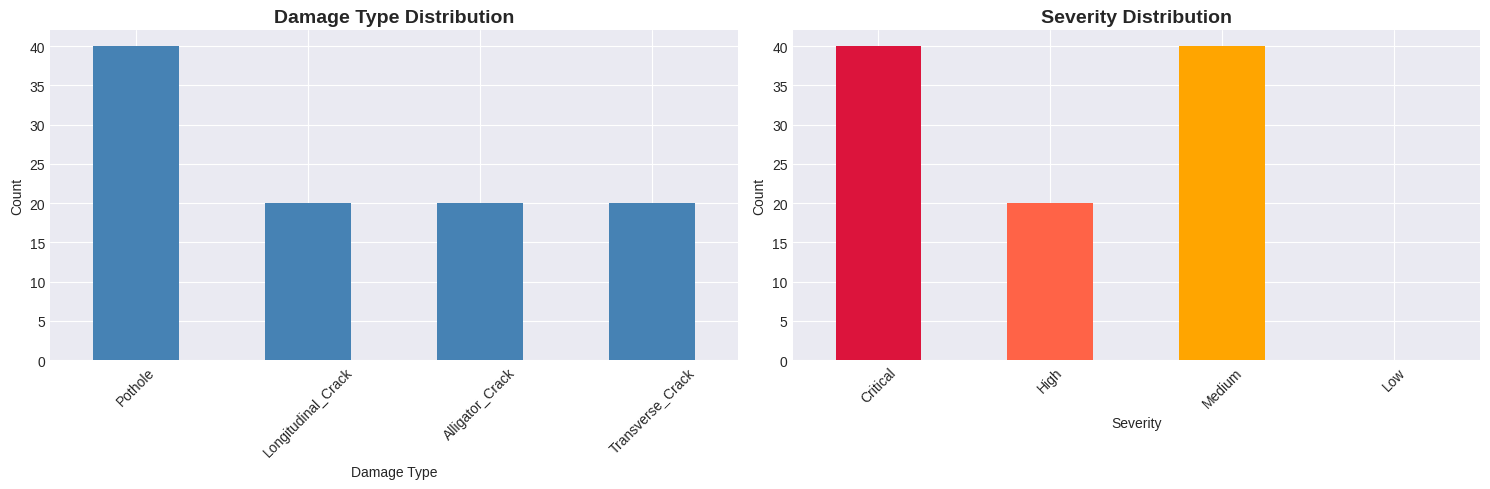

✅ Distribution charts saved


In [ ]:
# Damage distribution
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Damage type distribution
gdf['damage_type'].value_counts().plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Damage Type Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Damage Type')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Severity distribution - Updated with .reindex to handle missing categories
severity_order = ['Critical', 'High', 'Medium', 'Low']
severity_counts = gdf['severity'].value_counts().reindex(severity_order, fill_value=0)

severity_counts.plot(kind='bar', ax=axes[1],
                    color=['#DC143C', '#FF6347', '#FFA500', '#FFD700'])

axes[1].set_title('Severity Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Severity')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('outputs/visualizations/damage_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Distribution charts saved")

In [ ]:
# Create interactive map with Folium
def create_interactive_map(gdf):
    """
    Create interactive Folium map
    """
    # Calculate center
    center_lat = gdf['latitude'].mean()
    center_lon = gdf['longitude'].mean()

    # Create map
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=12,
        tiles='OpenStreetMap'
    )

    # Color mapping
    damage_colors = {
        'Longitudinal_Crack': '#FFD700',
        'Transverse_Crack': '#FFA500',
        'Alligator_Crack': '#FF6347',
        'Pothole': '#DC143C'
    }

    # Add markers
    for idx, row in gdf.iterrows():
        color = damage_colors.get(row['damage_type'], '#808080')

        popup_html = f"""
        <div style='width: 200px'>
            <h4 style='color: {color}'>{row['damage_type']}</h4>
            <b>Severity:</b> {row['severity']}<br>
            <b>Confidence:</b> {row['confidence']:.2%}<br>
            <b>Location:</b> {row['latitude']:.6f}, {row['longitude']:.6f}
        </div>
        """

        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=8,
            popup=folium.Popup(popup_html, max_width=250),
            color=color,
            fill=True,
            fillColor=color,
            fillOpacity=0.7,
            weight=2
        ).add_to(m)

    # Add legend
    legend_html = '''
    <div style="position: fixed;
                bottom: 50px; right: 50px; width: 200px; height: auto;
                background-color: white; z-index:9999; font-size:14px;
                border:2px solid grey; border-radius: 5px; padding: 10px">
    <p style="margin:0; font-weight: bold;">Damage Types</p>
    <p style="margin:5px 0;">
        <i style="background:#DC143C; width:15px; height:15px;
           float:left; margin-right:5px; border-radius:50%;"></i> Pothole
    </p>
    <p style="margin:5px 0;">
        <i style="background:#FF6347; width:15px; height:15px;
           float:left; margin-right:5px; border-radius:50%;"></i> Alligator Crack
    </p>
    <p style="margin:5px 0;">
        <i style="background:#FFA500; width:15px; height:15px;
           float:left; margin-right:5px; border-radius:50%;"></i> Transverse Crack
    </p>
    <p style="margin:5px 0;">
        <i style="background:#FFD700; width:15px; height:15px;
           float:left; margin-right:5px; border-radius:50%;"></i> Longitudinal Crack
    </p>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(legend_html))

    return m

# Create and save map
print("\n🗺️ Creating interactive map...")
damage_map = create_interactive_map(gdf)
damage_map.save('outputs/maps/damage_map.html')
print("✅ Interactive map saved to outputs/maps/damage_map.html")

# Display map in Colab
damage_map


🗺️ Creating interactive map...
✅ Interactive map saved to outputs/maps/damage_map.html


In [ ]:
# Create heatmap
def create_heatmap(gdf):
    """
    Create damage density heatmap
    """
    center_lat = gdf['latitude'].mean()
    center_lon = gdf['longitude'].mean()

    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=12,
        tiles='OpenStreetMap'
    )

    # Prepare heat data
    heat_data = [[row['latitude'], row['longitude']] for idx, row in gdf.iterrows()]

    # Add heatmap
    plugins.HeatMap(
        heat_data,
        radius=15,
        blur=25,
        max_zoom=13,
        gradient={0.4: 'blue', 0.65: 'lime', 0.8: 'yellow', 1.0: 'red'}
    ).add_to(m)

    return m

print("\n🔥 Creating heatmap...")
heatmap = create_heatmap(gdf)
heatmap.save('outputs/maps/heatmap.html')
print("✅ Heatmap saved to outputs/maps/heatmap.html")

heatmap


🔥 Creating heatmap...
✅ Heatmap saved to outputs/maps/heatmap.html


In [ ]:
# Create cluster map
def create_cluster_map(gdf):
    """
    Create map with marker clusters
    """
    center_lat = gdf['latitude'].mean()
    center_lon = gdf['longitude'].mean()

    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=12
    )

    # Create marker cluster
    marker_cluster = plugins.MarkerCluster().add_to(m)

    # Add markers
    for idx, row in gdf.iterrows():
        popup_html = f"""
        <div style='width: 200px'>
            <h4>{row['damage_type']}</h4>
            <b>Severity:</b> {row['severity']}<br>
            <b>Confidence:</b> {row['confidence']:.2%}
        </div>
        """

        icon_color = 'red' if row['severity'] == 'Critical' else 'orange'

        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=folium.Popup(popup_html, max_width=250),
            icon=folium.Icon(color=icon_color, icon='exclamation-triangle', prefix='fa')
        ).add_to(marker_cluster)

    return m

print("\n📍 Creating cluster map...")
cluster_map = create_cluster_map(gdf)
cluster_map.save('outputs/maps/cluster_map.html')
print("✅ Cluster map saved to outputs/maps/cluster_map.html")

cluster_map


📍 Creating cluster map...
✅ Cluster map saved to outputs/maps/cluster_map.html


In [ ]:
# Export to GeoJSON
geojson_path = 'outputs/maps/damages.geojson'
gdf.to_file(geojson_path, driver='GeoJSON')
print(f"✅ GeoJSON exported to {geojson_path}")

# Preview GeoJSON
with open(geojson_path, 'r') as f:
    geojson_data = json.load(f)

print(f"\nGeoJSON features: {len(geojson_data['features'])}")
print(f"\nFirst feature:")
print(json.dumps(geojson_data['features'][0], indent=2))

✅ GeoJSON exported to outputs/maps/damages.geojson

GeoJSON features: 100

First feature:
{
  "type": "Feature",
  "properties": {
    "damage_type": "Pothole",
    "severity": "Critical",
    "confidence": 0.89,
    "latitude": 23.04808,
    "longitude": 72.583237
  },
  "geometry": {
    "type": "Point",
    "coordinates": [
      72.583237,
      23.04808
    ]
  }
}


In [ ]:
# Download all outputs
from google.colab import files
import zipfile
import os

# Create ZIP of outputs
print("\n바 Creating output package...")

zip_filename = 'road_damage_outputs.zip'
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Add all output files
    # Renamed 'files' to 'filenames' to avoid shadowing the colab module
    for root, dirs, filenames in os.walk('outputs'):
        for file in filenames:
            file_path = os.path.join(root, file)
            zipf.write(file_path)

    # Add model
    if os.path.exists('models/best.pt'):
        zipf.write('models/best.pt')

print(f"✅ Package created: {zip_filename}")
print("\n다 Downloading package...")

# Download
files.download(zip_filename)

print("\n✅ All outputs downloaded!")


바 Creating output package...
✅ Package created: road_damage_outputs.zip

다 Downloading package...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ All outputs downloaded!


In [ ]:
# Generate comprehensive report
def generate_report(gdf):
    """
    Generate statistical report
    """
    report = {
        'timestamp': datetime.now().isoformat(),
        'total_detections': len(gdf),
        'damage_by_type': gdf['damage_type'].value_counts().to_dict(),
        'severity_distribution': gdf['severity'].value_counts().to_dict(),
        'average_confidence': float(gdf['confidence'].mean()),
        'confidence_by_damage': gdf.groupby('damage_type')['confidence'].mean().to_dict(),
        'geographic_extent': {
            'min_lat': float(gdf['latitude'].min()),
            'max_lat': float(gdf['latitude'].max()),
            'min_lon': float(gdf['longitude'].min()),
            'max_lon': float(gdf['longitude'].max())
        }
    }

    return report

report = generate_report(gdf)

print("\n📊 COMPREHENSIVE REPORT")
print("=" * 60)
print(json.dumps(report, indent=2))
print("=" * 60)

# Save report
with open('outputs/analysis_report.json', 'w') as f:
    json.dump(report, f, indent=2)

print("\n✅ Report saved to outputs/analysis_report.json")


📊 COMPREHENSIVE REPORT
{
  "timestamp": "2026-02-07T12:02:12.640901",
  "total_detections": 100,
  "damage_by_type": {
    "Pothole": 40,
    "Longitudinal_Crack": 20,
    "Alligator_Crack": 20,
    "Transverse_Crack": 20
  },
  "severity_distribution": {
    "Critical": 40,
    "Medium": 40,
    "High": 20
  },
  "average_confidence": 0.818,
  "confidence_by_damage": {
    "Alligator_Crack": 0.82,
    "Longitudinal_Crack": 0.76,
    "Pothole": 0.9,
    "Transverse_Crack": 0.71
  },
  "geographic_extent": {
    "min_lat": 22.973744,
    "max_lat": 23.071324,
    "min_lon": 72.521514,
    "max_lon": 72.621026
  }
}

✅ Report saved to outputs/analysis_report.json
